# Power Spectrum of Each Channel

using `wavelet transformation`

- preview single day data
- preview days average data
- group export days average data

In [1]:
import EEGAnalysis as ea
import h5py
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import re, os
from tqdm import tqdm

In [2]:
patient_id = 'zhangchen'

ea_manager = ea.DataManager('/media/STORAGE/EEG/Data')  ## create data manager
patient = ea_manager.create_patient(patient_id)  ## create new patient
# patient = ea_manager.get_patient(patient_id)  ## load previous patient

##### Constants #####
_freq = 2000
ROI = (-3, 3)
frange = np.logspace(np.log10(1), np.log10(150), 40)

zbase = (-2,-1)
tspec = np.linspace(ROI[0], ROI[1], int(_freq)*(ROI[1]-ROI[0]))

In [4]:
patient.get_marker().file.unique()

array(['190315-1', '190323-1', '190315-3', '190319-2', '190322-1',
       '190316-1', '190317-2', '190315-2', '190317-1', '190318-2',
       '190323-3', '190322-2', '190318-3', '190317-3', '190322-3',
       '190318-1', '190319-1', '190323-2', '190316-2', '190319-3',
       '190316-3'], dtype=object)

### preview single day data

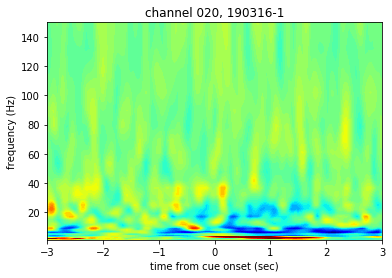

In [5]:
chidx = 20
_date = '190316-1'

_unit, _data, _ = patient.load_isplit(chidx, name=_date)[_date].values()
_marker = patient.get_marker(file=_date)[:20]   # first 20 markers for 10 sec trials, last 20 for 5 sec trials

##### preview plotting #####
_epoch = ea.create_1d_epoch_bymarker(_data, _marker, ROI, _freq)

_entry_dwt = ea.dwt.dwt(_epoch, int(_freq), frange, reflection=True)

entry_power = ea.decomposition.dwt_power(_entry_dwt, _freq, baseline=(zbase[0]-ROI[0], zbase[1]-ROI[0]))

_smooth = np.zeros_like(entry_power)
for idx in range(len(entry_power)):
    _smooth[idx] = ea.decomposition.gaussianwind(entry_power[idx,:], 2000, 0.05)

plt.contourf(tspec, frange, _smooth, 80, cmap=plt.get_cmap('jet'))
plt.clim((-3*np.std(entry_power), 3*np.std(entry_power)))

plt.title('channel %03d, %s'%(chidx, _date))
plt.xlabel('time from cue onset (sec)')
plt.ylabel('frequency (Hz)')
# plt.colorbar()
plt.show()

### preview days average data

100%|██████████| 21/21 [00:05<00:00,  3.55it/s]


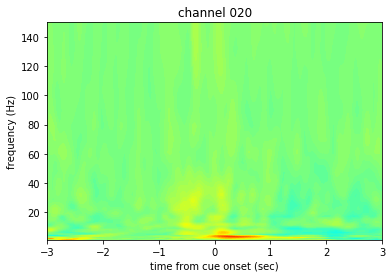

In [6]:
chidx = 20

_data_list = patient.load_isplit(chidx)
_dates = _data_list.keys()

_result = np.zeros((np.size(frange, 0), np.size(tspec)))
_valid_count = 0
for _idate in tqdm(_dates):
    if _idate[-1] != '1':  # only check out the specific paradigm
        continue
        
    _data = _data_list[_idate]['value']
    _marker = patient.get_marker(file=_idate)[:20]  # first 20 markers for 10 sec trials, last 20 for 5 sec trials
    
    _epoch = ea.create_1d_epoch_bymarker(_data, _marker, ROI, _freq)
    _entry_dwt = ea.dwt.dwt(_epoch, int(_freq), frange, reflection=True)
    entry_power = ea.decomposition.dwt_power(_entry_dwt, _freq, baseline=(zbase[0]-ROI[0], zbase[1]-ROI[0]))
    _result += entry_power
    _valid_count += 1
    
_result /= _valid_count
_smooth = np.zeros_like(_result)
for idx in range(len(entry_power)):
    _smooth[idx] = ea.decomposition.gaussianwind(_result[idx,:], 2000, 0.05)

plt.contourf(tspec, frange, _smooth, 80, cmap=plt.get_cmap('jet'))
plt.clim((-3*np.std(entry_power), 3*np.std(entry_power)))

plt.title('channel %03d'%(chidx))
plt.xlabel('time from cue onset (sec)')
plt.ylabel('frequency (Hz)')
# plt.colorbar()
plt.show()

### group export: days average data

In [6]:
_total_ch = len(patient._sgch_config['chidx'])
export_dir = './export/zhangchen_pwr_spectrum_5-2'
_paradigm = '2'
_interval = '5'

_raw_trace = {}

if not os.path.isdir(export_dir):
    os.mkdir(export_dir)
    os.chmod(export_dir, 0o775)

plt.figure(figsize=(8,6))
for chidx in tqdm(range(_total_ch)):

    _data_list = patient.load_isplit(chidx)
    _dates = _data_list.keys()

    _result = np.zeros((np.size(frange, 0), np.size(tspec)))
    _valid_count = 0
    for _idate in _dates:
        if _idate[-1] != _paradigm:  # only check out the specific paradigm
            continue

        _data = _data_list[_idate]['value']
        
        # first 20 markers for 10 sec trials, last 20 for 5 sec trials
        if interval == '5':
            _marker = patient.get_marker(file=idate)[20:]
        elif interval == '10':
            _marker = patient.get_marker(file=idate)[:20]
        else:
            raise ValueError("unkown paradigm code: %s"%paradigm)

        _epoch = ea.create_1d_epoch_bymarker(_data, _marker, ROI, _freq)
        _entry_dwt = ea.dwt.dwt(_epoch, int(_freq), frange, reflection=True)
        entry_power = ea.decomposition.dwt_power(_entry_dwt, _freq, baseline=(zbase[0]-ROI[0], zbase[1]-ROI[0]))
        _result += entry_power
        _valid_count += 1

    _result /= _valid_count
    _smooth = np.zeros_like(_result)
    for idx in range(len(entry_power)):
        _smooth[idx] = ea.decomposition.gaussianwind(_result[idx,:], 2000, 0.05)

    plt.contourf(tspec, frange, _smooth, 80, cmap=plt.get_cmap('jet'))
    plt.clim((-3*np.std(entry_power), 3*np.std(entry_power)))

    plt.title('channel %03d'%(chidx))
    plt.xlabel('time from cue onset (sec)')
    plt.ylabel('frequency (Hz)')
    # plt.colorbar()
    plt.savefig(os.path.join(export_dir, 'channel%03d.png'%chidx), bbox_inches='tight')
    plt.clf()

100%|██████████| 91/91 [37:10<00:00, 24.00s/it]  


<Figure size 576x432 with 0 Axes>

---